# Assignment 6 - time series modeling

# Instructions
1. Extract 10 years of weekly data for the QQQ stock ticker and visualize the data to better understand trends.
This should include a derived variable that shows weekly changes in close values.

2. Evaluate the dataset stationarity using the Dickey-Fuller Test. Explain the results.

3. Evaluate the dataset for trend, seasonality, and residuals - show charts for each component.

4. Build an ARIMA model using all data except for the most recent 13 data points (1 quarter).

Visualize the actual vs. predicted data for all data points included in the model.

5. Predict the most 13 data points and compare the predictions to actual stock market performance.

In [ ]:
import sys
!{sys.executable} -m pip install yfinance statsmodels

In [2]:
import pandas as pd
import numpy as np
import yfinance
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [56]:
# Get QQQ data, an ETF that tracks S&P 500
# Print out available data

stock_ticker = 'QQQ'

stock_info = yfinance.Ticker(stock_ticker)
for key,value in stock_info.info.items():
    print(key, ":", value)

longBusinessSummary : To maintain the correspondence between the composition and weights of the securities in the trust (the "securities") and the stocks in the NASDAQ-100 Index®, the adviser adjusts the securities from time to time to conform to periodic changes in the identity and/or relative weights of index securities. The composition and weighting of the securities portion of a portfolio deposit are also adjusted to conform to changes in the index.
maxAge : 86400
priceHint : 2
previousClose : 476.72
open : 476.52
dayLow : 476.05
dayHigh : 479.26
regularMarketPreviousClose : 476.72
regularMarketOpen : 476.52
regularMarketDayLow : 476.05
regularMarketDayHigh : 479.26
trailingPE : 39.074837
volume : 23372620
regularMarketVolume : 23372620
averageVolume : 38148587
averageVolume10days : 26468500
averageDailyVolume10Day : 26468500
bid : 479.13
ask : 479.96
bidSize : 900
askSize : 4200
yield : 0.0058
totalAssets : 270069170176
fiftyTwoWeekLow : 342.35
fiftyTwoWeekHigh : 479.26
fiftyDayAv

In [4]:
# Get 10 years of historic weekly price data

start_date = '2014-03-10'
end_date = '2024-03-10'

stock_info_price = stock_info.history(start=start_date, end=end_date, interval='1wk')
stock_info_price.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2014-03-10 00:00:00-04:00,83.194996,83.728292,81.493943,81.530724,160867500,0.000,0.0,0.0
2014-03-17 00:00:00-04:00,82.054827,83.360500,81.677841,81.834152,194975300,0.206,0.0,0.0
2014-03-24 00:00:00-04:00,82.316190,82.380701,79.625157,80.224190,265068600,0.000,0.0,0.0
2014-03-31 00:00:00-04:00,80.850855,82.647948,79.385528,79.597496,268772000,0.000,0.0,0.0
2014-04-07 00:00:00-04:00,79.099864,80.989114,77.330418,77.514732,348493700,0.000,0.0,0.0


[Text(0.5, 1.0, 'Daily Close Values over Time')]

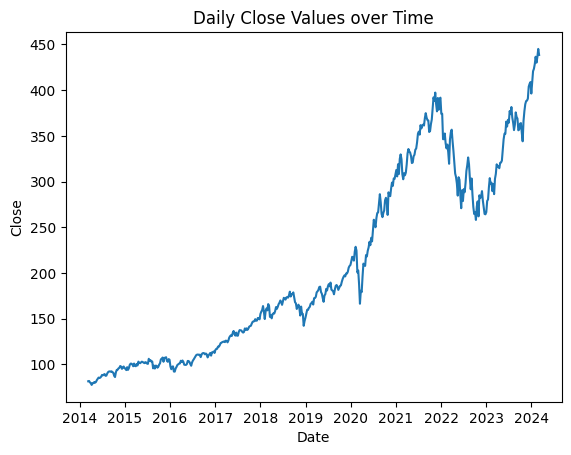

In [5]:
# Plot price change over time

sns.lineplot(stock_info_price, x='Date', y='Close').set(title='Daily Close Values over Time')

In [6]:
# We'll model on the log of daily changes to minimize some variation

stock_info_price['weekly_return'] = stock_info_price['Close'].diff()
stock_info_price.dropna(inplace=True)
stock_info_price.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,weekly_return
Date,,,,,,,,,
2014-03-17 00:00:00-04:00,82.054827,83.360500,81.677841,81.834152,194975300,0.206,0.0,0.0,0.303429
2014-03-24 00:00:00-04:00,82.316190,82.380701,79.625157,80.224190,265068600,0.000,0.0,0.0,-1.609962
2014-03-31 00:00:00-04:00,80.850855,82.647948,79.385528,79.597496,268772000,0.000,0.0,0.0,-0.626694
2014-04-07 00:00:00-04:00,79.099864,80.989114,77.330418,77.514732,348493700,0.000,0.0,0.0,-2.082764
2014-04-14 00:00:00-04:00,78.196685,79.837109,76.749793,79.440826,231822600,0.000,0.0,0.0,1.926094


[Text(0.5, 1.0, 'Daily Return Values over Time')]

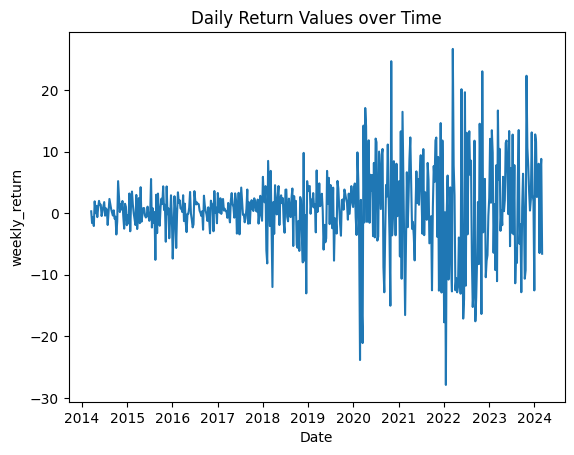

In [7]:
sns.lineplot(stock_info_price, x='Date', y='weekly_return').set(title='Daily Return Values over Time')

In [8]:
# Apply Dickey Fuller test
# Look at raw vs. daily return

# Raw

ad_fuller = adfuller(stock_info_price['Close'])
print('Augmented Dickey Fuller test on raw close data')
print(ad_fuller)
ad_fuller_daily = adfuller(stock_info_price['weekly_return'])
print('Augmented Dickey Fuller test on daily return')
print(ad_fuller_daily)

Augmented Dickey Fuller test on raw close data
(0.48472478461027096, 0.9844013486825444, 0, 520, {'1%': -3.4429882202506255, '5%': -2.8671142122781066, '10%': -2.569738849852071}, 3329.0228599314246)
Augmented Dickey Fuller test on daily return
(-23.653825304561433, 0.0, 0, 520, {'1%': -3.4429882202506255, '5%': -2.8671142122781066, '10%': -2.569738849852071}, 3328.4116942769065)


Note that for the SPY ticker at least, on the raw close data the ADF statistic is not more negative than the critical values, and the p value is high, indicating the data is not stationary

For the daily return data, the ADF statistic is less than the critical values and the p value is very low, indicating the data is stationary. We will use the daily return data for this exercise

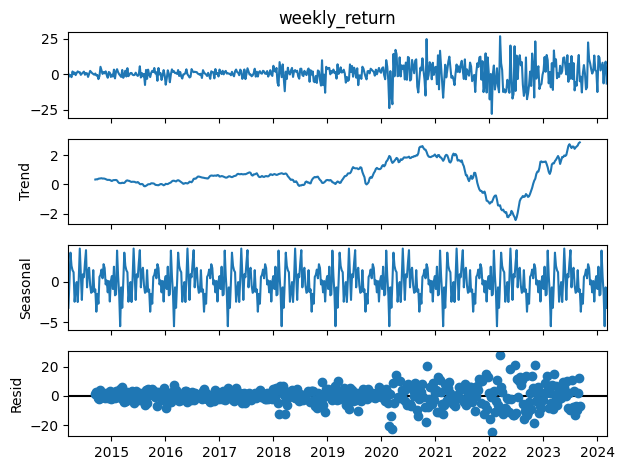

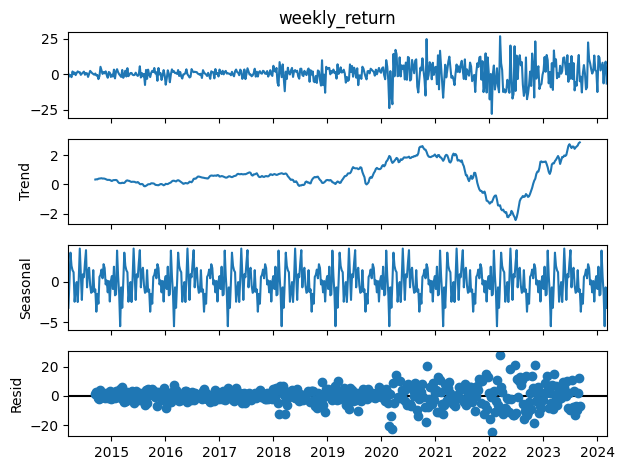

In [9]:
# Decompose seasonality and trend

decompose_dataset = pd.DataFrame({'weekly_return': stock_info_price['weekly_return'], 'date': pd.to_datetime(stock_info_price.index)})
decompose_dataset = decompose_dataset.set_index('date')
decompose_dataset.index.freq = 'W-MON' # Necessary to get seasonal_decompose to execute

decomposition = seasonal_decompose(decompose_dataset['weekly_return'], model='additive')
trend = pd.DataFrame(decomposition.trend)
seasonal = pd.DataFrame(decomposition.seasonal)
residual = pd.DataFrame(decomposition.resid)
decomposition.plot()

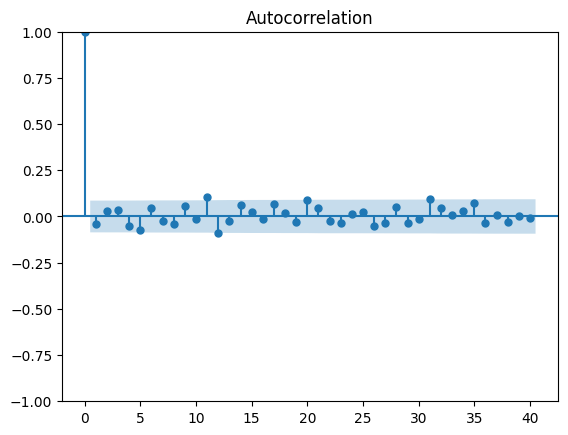

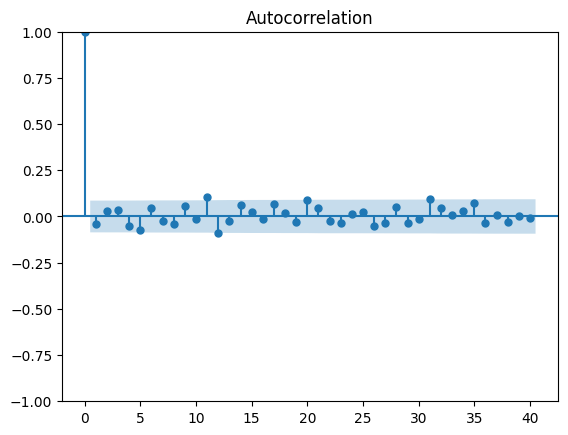

In [10]:
plot_acf(stock_info_price['weekly_return'], lags = 40)

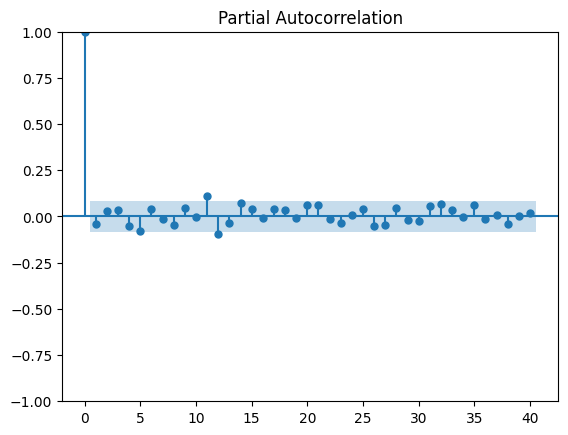

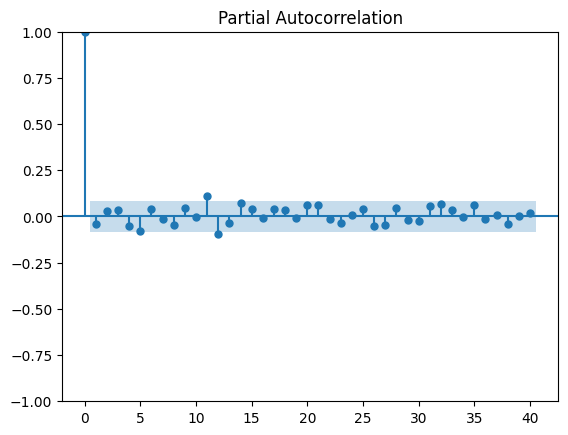

In [11]:
plot_pacf(stock_info_price['weekly_return'], lags = 40)

In [ ]:
# Let's use all data until 2024 to train the model, then predict 2024 data from there

stock_info_train = stock_info_price[stock_info_price.index < '2024-01-01']
stock_info_test = stock_info_price[stock_info_price.index >= '2024-01-01']
arima = ARIMA(stock_info_train['Close'], order=(20,1,13))

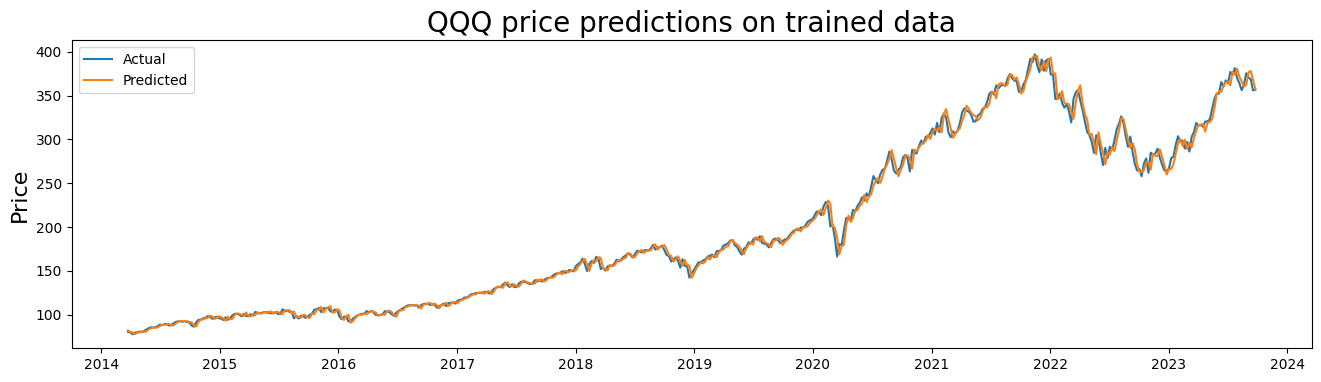

In [51]:
# Lines up really close with historic data
# But a closer inspection shows it's a day or so behind, but catches up quickly

plt.figure(figsize=(16,4))
plt.plot(stock_info_train['Close'][1:-13], label="Actual")
plt.plot(train_preds[1:-13], label="Predicted")
plt.title(f'{stock_ticker} price predictions on trained data', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.legend()

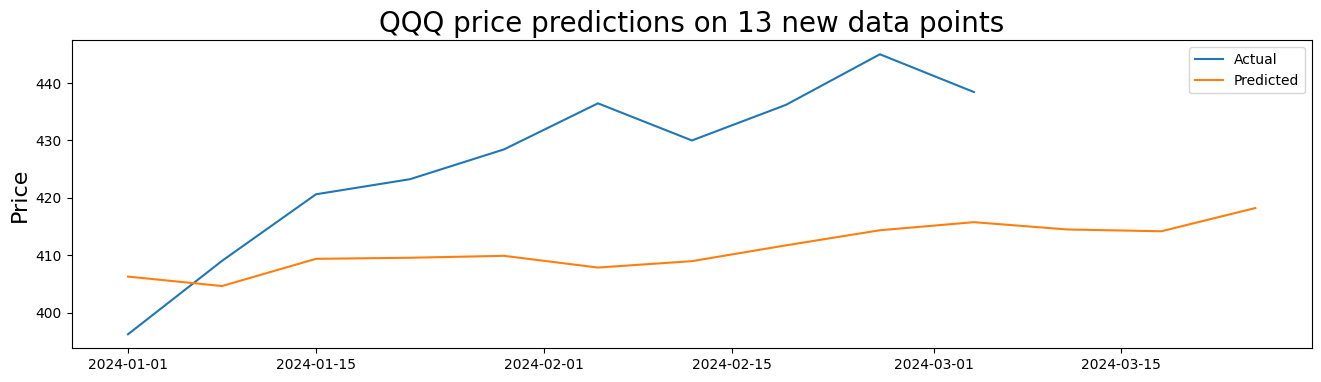

In [55]:


plt.figure(figsize=(16,4))
plt.plot(stock_info_test['Close'], label="Actual")
plt.plot(test_preds, label="Predicted")
plt.title(f'{stock_ticker} price predictions on 13 new data points', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.legend()